# 範例 : (Kaggle)房價預測
<br />
分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看<br />
https://www.kaggle.com/c/house-prices-advanced-regression-techniques/submit<br />
<br /><br /> 

## [教學目標]
<br />
以下用房價預測資料, 觀查混合泛化 (Blending) 的寫法與效果<br />
<br /><br />

## [範例重點]
<br />
觀察混合泛化的準確度 (In[12]), 是否比單一模型準確度為高 (In[9~11])<br />
除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響<br />

In [40]:
import numpy as np
import pandas as pd
import copy
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

data_path = './data/'
train_df = pd.read_csv(data_path + 'train.csv')
test_df = pd.read_csv(data_path + 'test.csv')

train_label = train_df.SalePrice
train_label = np.log1p(train_label.values)
train_df = train_df.drop(['Id','SalePrice'], axis = 1)
test_ids = test_df['Id']
test_df = test_df.drop(['Id'], axis = 1)

total_df = pd.concat([train_df, test_df], axis = 0)
total_df.head(5)

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


In [42]:
def CheckMissingVals(data):
    for col in data.columns:
        if np.sum(data[col].isnull()):
            print(f' Missing ratio in {col} : {np.sum(data[col].isnull()) / len(data) * 100} %')

CheckMissingVals(total_df)            

 Missing ratio in MSZoning : 0.1370332305584104 %
 Missing ratio in LotFrontage : 16.649537512846866 %
 Missing ratio in Alley : 93.21685508735868 %
 Missing ratio in Utilities : 0.0685166152792052 %
 Missing ratio in Exterior1st : 0.0342583076396026 %
 Missing ratio in Exterior2nd : 0.0342583076396026 %
 Missing ratio in MasVnrType : 0.8221993833504625 %
 Missing ratio in MasVnrArea : 0.7879410757108599 %
 Missing ratio in BsmtQual : 2.774922918807811 %
 Missing ratio in BsmtCond : 2.8091812264474134 %
 Missing ratio in BsmtExposure : 2.8091812264474134 %
 Missing ratio in BsmtFinType1 : 2.7064063035286057 %
 Missing ratio in BsmtFinSF1 : 0.0342583076396026 %
 Missing ratio in BsmtFinType2 : 2.7406646111682083 %
 Missing ratio in BsmtFinSF2 : 0.0342583076396026 %
 Missing ratio in BsmtUnfSF : 0.0342583076396026 %
 Missing ratio in TotalBsmtSF : 0.0342583076396026 %
 Missing ratio in Electrical : 0.0342583076396026 %
 Missing ratio in BsmtFullBath : 0.0685166152792052 %
 Missing ratio 

In [43]:
none_cols = ['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 'FireplaceQu', 
            'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 
             'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'Functional', 'MSSubClass']
zero_cols = ['GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 
             'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea']

for col in none_cols:
    total_df[col] = total_df[col].fillna('None')
for col in zero_cols:
    total_df[col] = total_df[col].fillna(0)

CheckMissingVals(total_df)

 Missing ratio in MSZoning : 0.1370332305584104 %
 Missing ratio in LotFrontage : 16.649537512846866 %
 Missing ratio in Utilities : 0.0685166152792052 %
 Missing ratio in Exterior1st : 0.0342583076396026 %
 Missing ratio in Exterior2nd : 0.0342583076396026 %
 Missing ratio in Electrical : 0.0342583076396026 %
 Missing ratio in KitchenQual : 0.0342583076396026 %
 Missing ratio in SaleType : 0.0342583076396026 %


In [44]:
# fill some part of missing with mode val
mode_cols = ['MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType']
for col in mode_cols:
    total_df[col] = total_df[col].fillna(total_df[col].mode()[0])
    
# fillna missing vals in LotFrontage with median vals in same Neighborhood
total_df['LotFrontage'] = total_df.groupby(['Neighborhood'])['LotFrontage'].transform(lambda x : x.fillna(x.median()))

total_df = total_df.drop(['Utilities'], axis = 1)

In [45]:
CheckMissingVals(total_df)

In [46]:
label_cols = ['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']
for col in label_cols:
    total_df[col] = total_df[col].astype(str)

cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

for col in cols:
    total_df[col] = LabelEncoder().fit_transform(total_df[col].values)

total_df['TotalSF'] = total_df['TotalBsmtSF'] + total_df['1stFlrSF'] + total_df['2ndFlrSF'] 

print('Shape total df : {}' .format(total_df.shape))
total_df.head(5)

Shape total df : (2919, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,LotConfig,LandSlope,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,TotalSF
0,10,RL,65.0,8450,1,1,3,Lvl,Inside,0,...,0,3,4,None,0,4,2,WD,Normal,2566.0
1,5,RL,80.0,9600,1,1,3,Lvl,FR2,0,...,0,3,4,None,0,7,1,WD,Normal,2524.0
2,10,RL,68.0,11250,1,1,0,Lvl,Inside,0,...,0,3,4,None,0,11,2,WD,Normal,2706.0
3,11,RL,60.0,9550,1,1,0,Lvl,Corner,0,...,0,3,4,None,0,4,0,WD,Abnorml,2473.0
4,10,RL,84.0,14260,1,1,0,Lvl,FR2,0,...,0,3,4,None,0,3,2,WD,Normal,3343.0


In [47]:
total_df = pd.get_dummies(total_df)
total_df.shape

(2919, 221)

In [48]:
train_x = total_df[:len(train_label)]
test_x = total_df[len(train_label):]

from sklearn.ensemble import RandomForestRegressor

linear = LinearRegression(normalize = False, fit_intercept = True, copy_X = True)
gdbt = GradientBoostingRegressor(tol=0.1, subsample=0.37, n_estimators=200, max_features=20, 
                                 max_depth=6, learning_rate=0.03)
rf = RandomForestRegressor(n_estimators=300, min_samples_split=9, min_samples_leaf=10, 
                           max_features='sqrt', max_depth=8, bootstrap=False)

In [49]:
gdbt.fit(train_x,train_label)
gdbt_pred = gdbt.predict(test_x)

In [51]:
rf.fit(train_x, train_label)
rf_pred = rf.predict(test_x)

In [52]:
linear.fit(train_x,train_label)
linear_pred = linear.predict(test_x)

In [56]:
gdbt_pred = np.expm1(gdbt_pred)
rf_pred = np.expm1(rf_pred)
linear_pred = np.expm1(linear_pred)

blending_pred = linear_pred*0.3 + gdbt_pred*0.67 + rf_pred*0.03
submission = pd.DataFrame({'Id':test_ids, 'SalePrice' : blending_pred})
submission.to_csv('house_blending.csv', index = False)

# 作業 : (Kaggle)鐵達尼生存預測
<br />
分數以網站評分結果為準, 請同學實際將提交檔(*.csv)上傳試試看<br />
https://www.kaggle.com/c/titanic/submit <br />

 <br /><br />
## [作業目標]

<br />
試著模仿範例寫法, 在鐵達尼生存預測中, 觀察觀查混合泛化 (Blending) 的寫法與效果<br />

<br /><br />
## [作業重點]

<br />
觀察混合泛化的準確度 , 是否比單一模型準確度為高 <br />
除了我們的權重, 同學也可以試著自行調整權重 (注意:權重和=1), 看看有什麼影響<br />
Hint : 除了權重, 分類預測的調整, 還可以調整什麼地方?<br />

In [120]:
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

train_df = pd.read_csv(data_path + 'titanic_train.csv')
test_df = pd.read_csv(data_path + 'titanic_test.csv')

train_label = train_df.Survived
test_ids = test_df.PassengerId

train_df = train_df.drop(['Survived', 'PassengerId'], axis = 1)
test_df = test_df.drop(['PassengerId'], axis = 1)

total_df = pd.concat([train_df,test_df], axis = 0)
total_df.head(5)

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [121]:
CheckMissingVals(total_df)

 Missing ratio in Age : 20.091673032849503 %
 Missing ratio in Fare : 0.07639419404125286 %
 Missing ratio in Cabin : 77.46371275783041 %
 Missing ratio in Embarked : 0.15278838808250572 %


In [122]:
#Encode female with 1 and male with 0
#I think female might would had better change to survive, so I replace the female to 1 like a data trending.
total_df['Sex'] = total_df['Sex'].map(lambda x : 1 if x == 'female' else 0)
#Fare with very small portion of missing, I will simply replace the NA with median val
total_df['Fare'] = total_df['Fare'].fillna(total_df['Fare'].median())

In [123]:
#The Name column has some interesting infromation. 
#There are some titles in the names, like 'Mr', 'Mrs' and 'Master'... 
#This might be helpful for our data processing.

total_df['Name'] = total_df['Name'].str.split(',').str[1].str.split('.').str[0].str.strip()

#Also we can change the column name with Title, since they are much like title now 
total_df = total_df.rename(columns = {'Name' : 'Title'})
total_df.Title.value_counts()

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Ms                2
Major             2
Don               1
the Countess      1
Capt              1
Dona              1
Sir               1
Lady              1
Mme               1
Jonkheer          1
Name: Title, dtype: int64

From above result, we use google and some common knowledge to know the meaning of these titles. <br />
Mr: Men which might be married or not.  <br />
Miss: Women which are not married yet.  <br />
Mrs: Women which are married.   <br />
Master : Prestigious title  <br />
Dr : might be doctor of professor <br />
Rev : might be reverend  <br />
Col : Boy Names  <br />
Ms: title of respect of women.  <br />
Major : might be some military rank  <br />
Mlle : French girls  <br />
the countess : respectful women title  <br />
Sir : respectful men title  <br />
Lady : respectful women title  <br />
Capt : This must be captain(but we dont sure the gender)  <br />
Jonkheer : respectful title  <br />
Don : Im not sure, but I assume it is a male title  <br />
Mme : Madame  <br />
Dona : Im not sure, but I assume it is a female title  <br />

In [124]:
#We can use above result to group title column
total_df.Title.replace(to_replace = ['Dr','Major','Capt','Sir','Rev','Jonkheer','Master','Lady','Ms','Mme','the Countess'], value = 'respect', inplace = True)
total_df.Title.replace(to_replace = ['Col','Don'], value = 'Mr', inplace = True)
total_df.Title.replace(to_replace = ['Mlle','Dona'], value = 'Miss', inplace = True)

#we can check the value_counts again after we group the title column
total_df.Title.value_counts()

Mr         762
Miss       263
Mrs        197
respect     87
Name: Title, dtype: int64

In [125]:
#Add few new features with SibSp and Parch features
#The whole family size of a single data is SibSp+Parch+1, one for himself/herself

total_df['Fsize'] = total_df['SibSp'] + total_df['Parch'] + 1
total_df['Single'] = total_df['Fsize'].map(lambda x : 1 if x == 0 else 0)
total_df['SmallF'] = total_df['Fsize'].map(lambda x : 1 if x == 2 else 0)
total_df['MedF'] = total_df['Fsize'].map(lambda x : 1 if 3 <= x <= 4 else 0)
total_df['LargeF'] = total_df['Fsize'].map(lambda x : 1 if x >= 5 else 0)

In [126]:
#Simply replace the data in ticket without letter with X and elimate the extra notions in the data for other data
Ticket = []
for i in list(total_df.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])
    else:
        Ticket.append('X')
        
total_df['Ticket'] = Ticket
total_df = pd.get_dummies(total_df, columns = ['Ticket'], prefix = 'T')

In [127]:
#Simply replace the missing values in Cabin with X, which means the person with no Cabin
total_df['Cabin'] = total_df['Cabin'].fillna('X')
#And replace the values with data`s first letter to represent the Cabin label
total_df['Cabin'] = total_df['Cabin'].map(lambda x : x[0])

In [128]:
#One hot encoding the Cabin
total_df = pd.get_dummies(total_df, columns = ['Cabin'], prefix = 'Cabin_')

In [129]:
#Somply replace the missing values in Embarked with mode val
total_df['Embarked'] = total_df['Embarked'].fillna(total_df['Embarked'].mode()[0])
#One hot encoding the Embarked
total_df = pd.get_dummies(total_df, columns = ['Embarked'], prefix = 'Em_')

#Turn the Pclass into object type
total_df['Pclass'] = total_df['Pclass'].astype('category')
total_df = pd.get_dummies(total_df, columns = ['Pclass'], prefix = "Pc_")

In [130]:
CheckMissingVals(total_df)

 Missing ratio in Age : 20.091673032849503 %


In [131]:
#There are many missing values in Age data. So we could not simply fill the missing values with constant.
#We can use the other columns to fill the missing values of Age data.
#There are some columns might have large correaltion with Age, like title.
#So we can calculate the correlation between Age and other features first.
#But before that, we should turn the datas into numerical type first

temp = copy.deepcopy(total_df[total_df.columns[total_df.columns != 'Age']])
temp.Title.replace(to_replace = ['Mr'] , value = 0 , inplace = True)
temp.Title.replace(to_replace = ['Mrs'] , value = 1 , inplace = True)
temp.Title.replace(to_replace = ['Miss'] , value =  2, inplace = True)
temp.Title.replace(to_replace = ['respect'] , value = 3 , inplace = True)
temp = temp.agg(LabelEncoder().fit_transform)
temp['Age'] = total_df['Age']   
Corr = temp.corr()["Age"].apply(lambda x : abs(x)).sort_values(ascending = False)
print(Corr[:10])

#Also since the missing values of age is filling by ourself. 
#We should add an extra columns to tell the model that there are some age data was missing.
total_df['Missing_Age'] = total_df.Age.isnull()

Age         1.000000
Pc__1       0.393198
Title       0.340346
Pc__3       0.337069
Cabin__X    0.289740
SibSp       0.245152
Fsize       0.240592
T_PC        0.199506
Fare        0.192608
LargeF      0.178480
Name: Age, dtype: float64


In [132]:
#From above information, we can see that age column has larger correlation with 'Pclass' and 'Title'. 
#So I would like to use this column for missing filling of age.

total_df.Age = temp.groupby(['Pc__1','Pc__3','Title'])['Age'].transform(lambda v: v.fillna(v.median()))
CheckMissingVals(total_df)

In [133]:
#Also I would like to make a group for Age data
cuttingArr = np.array([0,20,40,60,total_df.Age.max()])
total_df['Age_Group'] = pd.cut(total_df.Age,cuttingArr,include_lowest = True)
print(total_df.Age_Group.value_counts())

(20.0, 40.0]      738
(-0.001, 20.0]    306
(40.0, 60.0]      232
(60.0, 80.0]       33
Name: Age_Group, dtype: int64


In [134]:
#Dont forget to one hot encoding the Title and Age Group features
total_df = pd.get_dummies(total_df, columns = ['Title'], prefix = 'Title')
total_df = pd.get_dummies(total_df, columns = ['Age_Group'], prefix = 'AG')

total_df.head(5)

,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,LargeF,...,Pc__3,Missing_Age,Title_Miss,Title_Mr,Title_Mrs,Title_respect,"AG_(-0.001, 20.0]","AG_(20.0, 40.0]","AG_(40.0, 60.0]","AG_(60.0, 80.0]"
0,0,22.0,1,0,7.2500,2,0,1,0,0,...,1,False,0,1,0,0,0,1,0,0
1,1,38.0,1,0,71.2833,2,0,1,0,0,...,0,False,0,0,1,0,0,1,0,0
2,1,26.0,0,0,7.9250,1,0,0,0,0,...,1,False,1,0,0,0,0,1,0,0
3,1,35.0,1,0,53.1000,2,0,1,0,0,...,0,False,0,0,1,0,0,1,0,0
4,0,35.0,0,0,8.0500,1,0,0,0,0,...,1,False,0,1,0,0,0,1,0,0


In [135]:
total_df['Missing_Age'] = total_df['Missing_Age'].map(lambda x : 1 if x == True else 0)

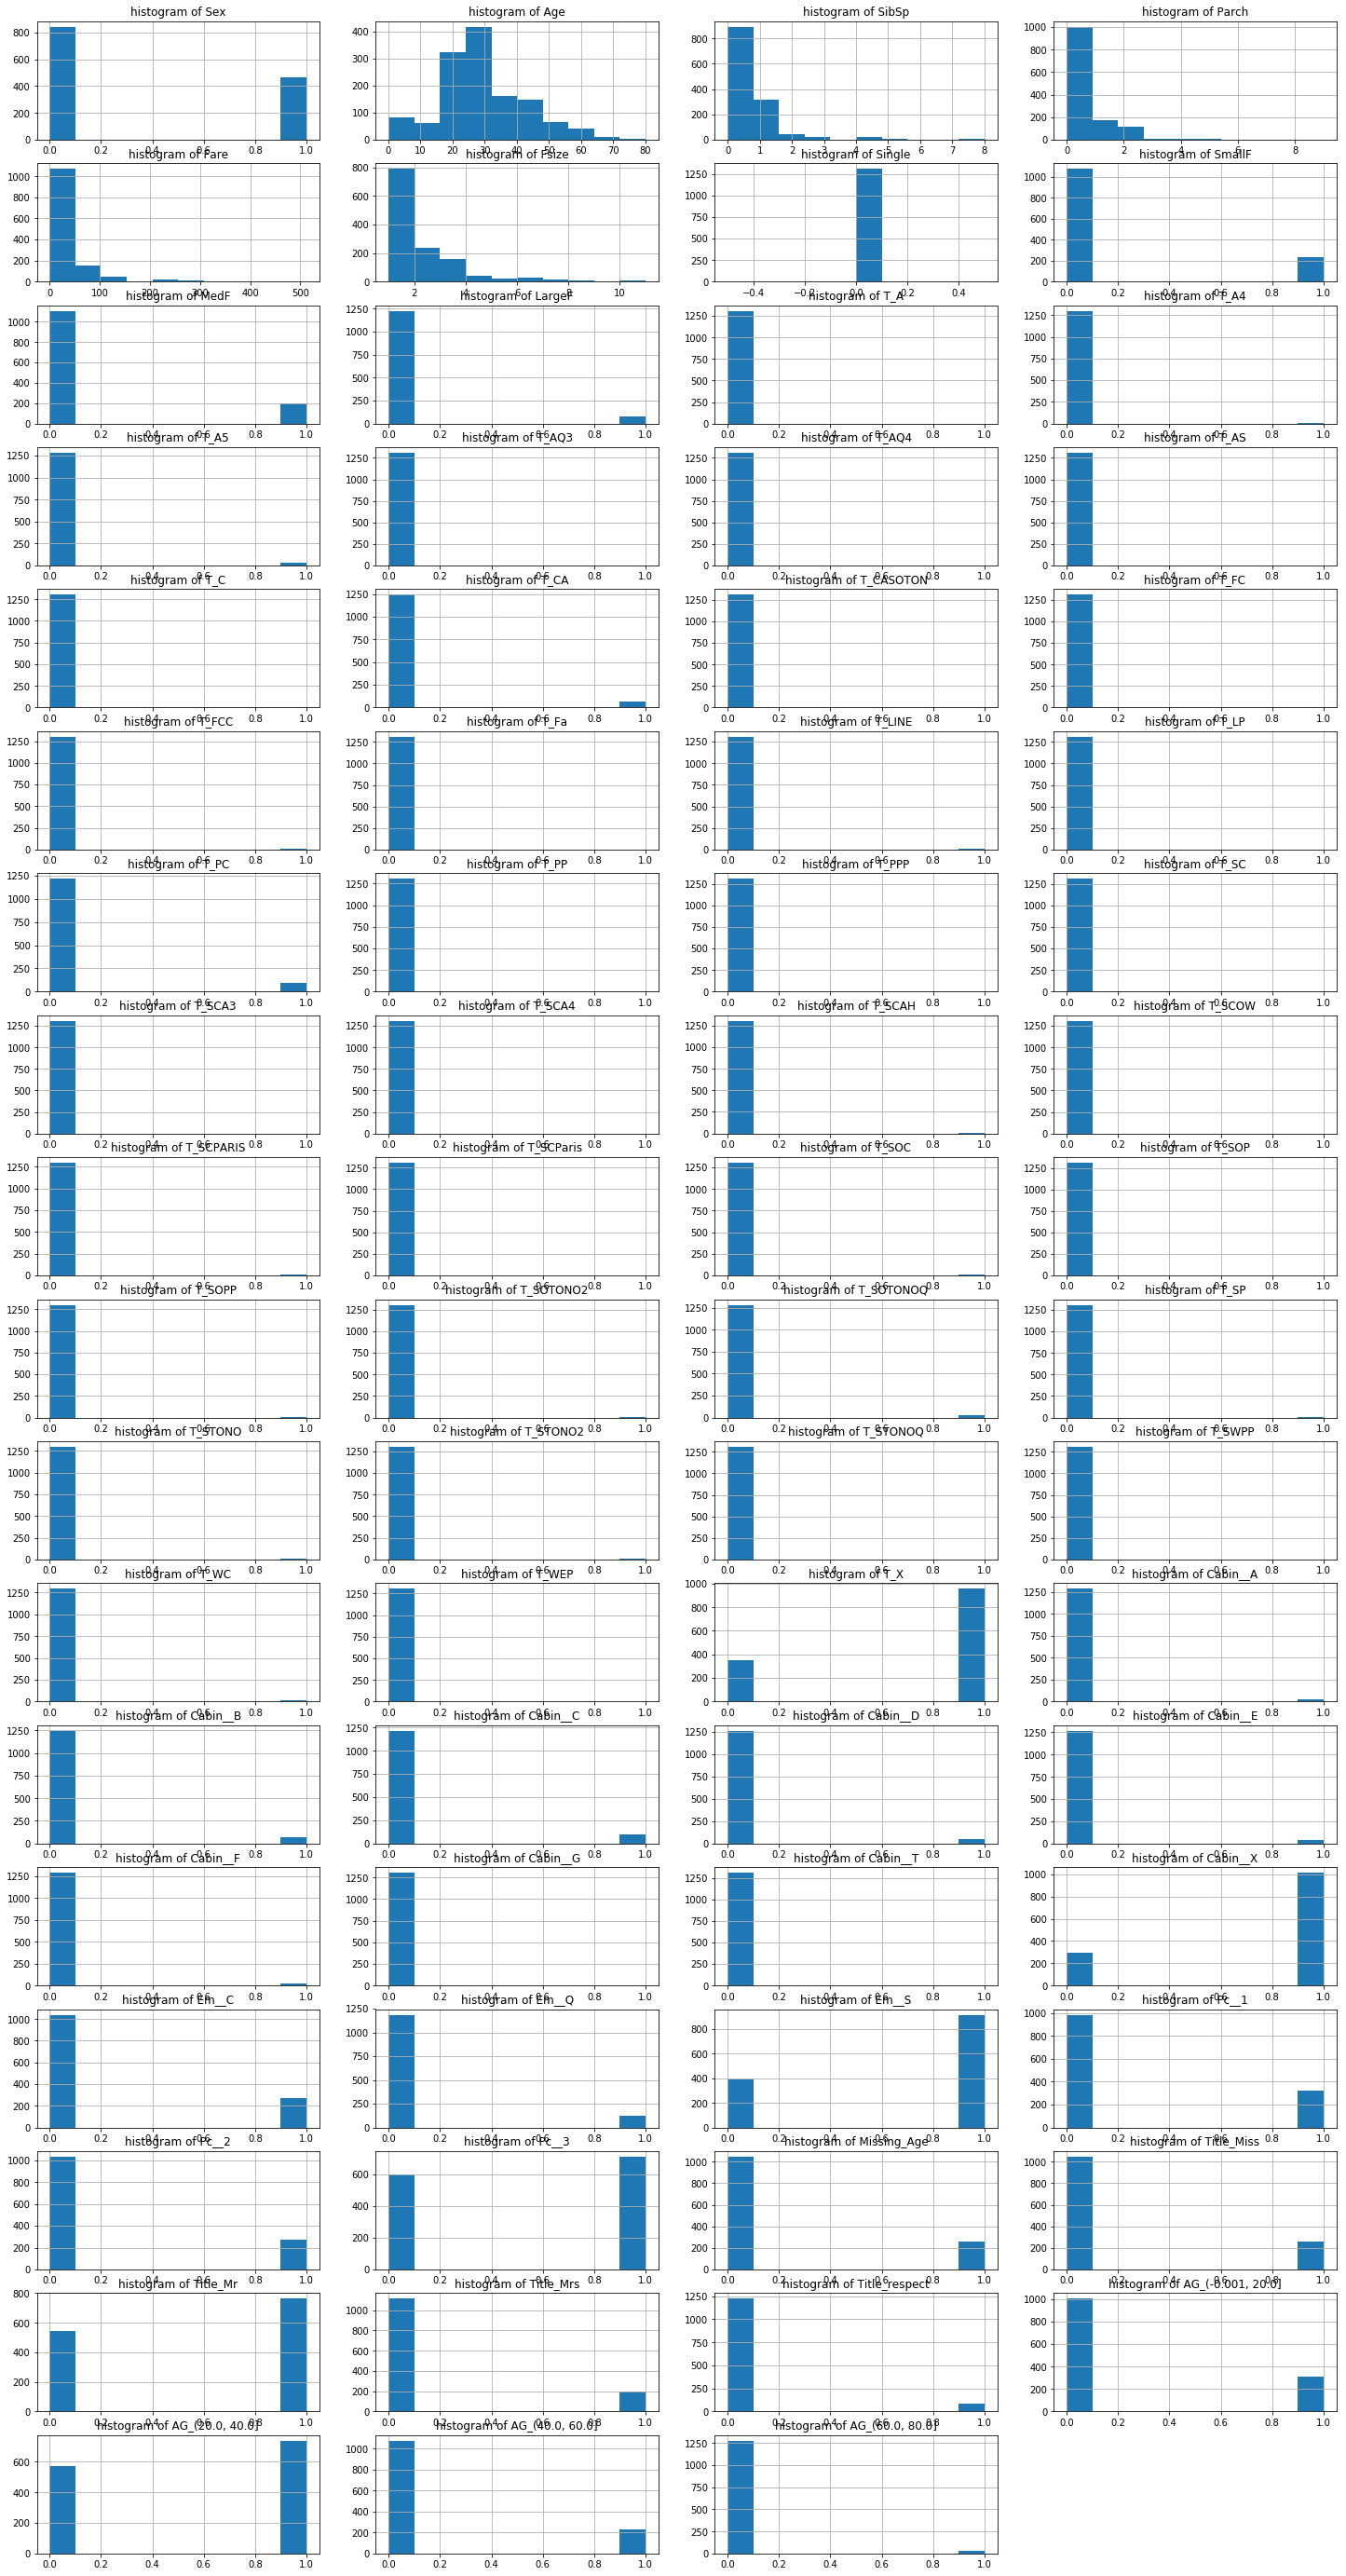

In [136]:
import matplotlib.pyplot as plt
import warnings 

warnings.filterwarnings('ignore')
#Here I want to see the data distribution by histogram
ncols = 4
nrows = len(total_df.columns) / ncols+1

plt.figure(figsize = (25,50))
for i,col in enumerate(total_df.columns):
    if col != 'PassengerId' :
        plt.subplot(nrows,ncols,i+1)
        total_df[col].hist()
        plt.title('histogram of %s' %col)

plt.show()

In [137]:
#Fixing the skewness of Fare feature
total_df['Fare'] = np.log1p(total_df['Fare'])
total_df.Fare.describe()

count    1309.000000
mean        2.979226
std         0.968321
min         0.000000
25%         2.185579
50%         2.737881
75%         3.474293
max         6.240917
Name: Fare, dtype: float64

In [138]:
total_df = MinMaxScaler().fit_transform(total_df)

train_x = total_df[:len(train_label)]
test_x = total_df[len(train_label):]

In [146]:
from sklearn.model_selection import  RandomizedSearchCV
#first we will tune the parameters of every model 
RFParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_split':np.arange(2,20,2), 'min_samples_leaf':np.arange(1,6,2) }

ETParams = {'n_estimators':np.arange(100,1100,50), 'max_depth':np.arange(3,11,2),
            'min_samples_leaf':np.arange(1,6,2) }

gbcParams = {'n_estimators' : np.arange(100,1100,50) , 'learning_rate' : np.arange(0.01,0.2,0.05) 
             , 'min_samples_split' : np.arange(2,20,2), 'min_samples_leaf' : np.arange(1,6,2),
              'max_depth' : np.arange(3,11,2), 'subsample' : np.arange(0.3,0.8,0.1), 'max_features' : np.arange(10,30,5) }

logParams = { 'C' : np.arange(0.1,1.5,0.2) }

#We use GridSearchCV to find the best params of the classifier
#cv = 5 means we will split data into 5 piece for cross validation.
#n_jobs = -1 means we want all the processor to run in parallel (cuz this might take a lot of estimation)
def tuneParams(classifier, params, train_x, train_y, cv = 5):
    md = GridSearchCV(classifier, params, cv = cv, scoring = 'accuracy', n_jobs = -1)
    md.fit(train_x,train_y)

    return md.best_params_,np.round(md.best_score_*100,2)

def tuneParamsRandom(classifier, params, train_x, train_y, cv=5):
    rs = RandomizedSearchCV(classifier, params, n_iter = 30,scoring = 'accuracy', n_jobs = -1, verbose = 0)
    rs.fit(train_x,train_y)
    
    return rs.best_params_, abs(rs.best_score_)

In [148]:
# we will use xgboost, adaBoost, randomForest, ExtraTrees, KNeighbors and SVC to be the classifier of our first step ensemble stacking
Log_best_Params, Log_best_score = tuneParamsRandom(LogisticRegression(tol = 0.001, fit_intercept = True), logParams, train_x, train_label)
print("LogisticRegression:",Log_best_Params,Log_best_score)

GBC_best_Params,GBC_best_score = tuneParamsRandom(GradientBoostingClassifier(),gbcParams,train_x,train_label)
print("GradientBoostingClassifier:",GBC_best_Params,GBC_best_score)

RF_best_Params,RF_best_score = tuneParamsRandom(RandomForestClassifier(),RFParams,train_x,train_label)
print("RandomForest:",RF_best_Params,RF_best_score)

ET_best_Params,ET_best_score = tuneParamsRandom(ExtraTreesClassifier(),ETParams,train_x,train_label)
print("ExtraTrees:",ET_best_Params,ET_best_score)

LogisticRegression: {'C': 1.3000000000000003} 0.8249158249158249
GradientBoostingClassifier: {'subsample': 0.7000000000000002, 'n_estimators': 450, 'min_samples_split': 10, 'min_samples_leaf': 3, 'max_features': 20, 'max_depth': 9, 'learning_rate': 0.01} 0.8305274971941639
RandomForest: {'n_estimators': 550, 'min_samples_split': 14, 'min_samples_leaf': 3, 'max_depth': 5} 0.8282828282828283
ExtraTrees: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 5} 0.8338945005611672


In [166]:
log = LogisticRegression(**Log_best_Params)
gbc = GradientBoostingClassifier(**GBC_best_Params)
rf = RandomForestClassifier(**RF_best_Params)
et = ExtraTreesClassifier(**ET_best_Params)

log.fit(train_x,train_label)
gbc.fit(train_x,train_label)
rf.fit(train_x,train_label)
et.fit(train_x,train_label)

log_pred = log.predict_proba(test_x)[:,1]
gbc_pred = gbc.predict_proba(test_x)[:,1]
rf_pred = rf.predict_proba(test_x)[:,1]
et_pred = et.predict_proba(test_x)[:,1]

# 作業
雖然同樣是混合泛化，分類預測其實與回歸預測有相當多的差異性， 因為鐵達尼預測的結果是 '生存/死亡'，輸出不是 0 就是 1 <br />
因此要用權重混合時，需要以以機率的形式混合，因此我們在作業前幾格當中，先幫各位同學把預測值寫成了機率的形式<br />
(請同學把下列程式完成，並將結果提交到 Kaggle 網站看看結果)<br />

但是光是這樣，分類問題的混合泛化就能比單模預測還要好嗎?<br />
已經快要期中考了，這裡請同學挑戰看看，還有沒有什麼方法可以改進混合泛化的結果?<br />

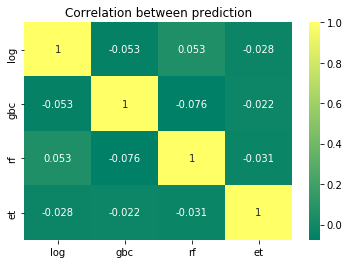

In [178]:
import seaborn as sns
#Check the correlation between predictions
classifiers = ['log','gbc','rf','et']
predictions = pd.DataFrame(np.vstack((log_pred,gbc_pred,rf_pred,et_pred)).reshape(-1,4), columns = classifiers )
pred_corr = predictions.corr()

sns.heatmap(pred_corr, cmap = plt.cm.summer , annot = True)
plt.title('Correlation between prediction')
plt.show()

In [181]:
blending_pred = 0.1 * log_pred + 0.25* rf_pred + 0.25*et_pred + 0.4*gbc_pred
submission = pd.DataFrame({'PassengerId' : test_ids , 'Survived' : blending_pred} )
submission['Survived'] = submission['Survived'].map(lambda x : 0 if x < 0.5 else 1)
submission.to_csv('titanic_blending.csv', index = False)

In [183]:
submission_log = pd.DataFrame({'PassengerId' : test_ids, 'Survived' : log_pred})
submission_log['Survived'] = submission_log['Survived'].map(lambda x : 0 if x<0.5 else 1)
submission_log.to_csv('titanic_log.csv', index = False)


submission_rf = pd.DataFrame({'PassengerId' : test_ids, 'Survived' : rf_pred})
submission_rf['Survived'] = submission_rf['Survived'].map(lambda x : 0 if x<0.5 else 1)
submission_rf.to_csv('titanic_rf.csv', index = False)

submission_gbc = pd.DataFrame({'PassengerId' : test_ids, 'Survived' : gbc_pred})
submission_gbc['Survived'] = submission_gbc['Survived'].map(lambda x : 0 if x<0.5 else 1)
submission_gbc.to_csv('titanic_gbc.csv', index = False)